In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
# load test images
test = []
for img in glob.glob('./test_images/*.jpg'):
    image = mpimg.imread(img)
    test.append(image)

car_test1 = glob.glob('./test_images/vehicles/KITTI_extracted/17.png')
test1 = (mpimg.imread(car_test1[0])*255).astype(np.uint8)
car_test2 = glob.glob('./test_images/vehicles/GTI_Far/image0001.png')

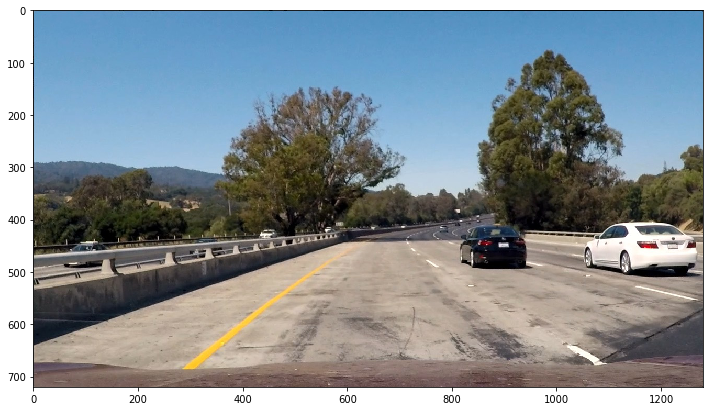

In [3]:
# test image example
img = test[3]
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.show()

In [4]:
# function to convert color-space
def convert_color(img, conv='YCrCb'):
    color = 'cv2.COLOR_RGB2{}'.format(conv)
    color = eval(color)
    return cv2.cvtColor(img, color)
    
# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # check if img grayscaled
    if len(img.shape) > 2:
        img = convert_color(img, 'GRAY')
    # if vis==True, return features and hog image
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # otherwise return only features
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # list to append feature vectors to
    features = []
    # iterate through the list of images
    for file in imgs:
        file_features = []
        if 'png' in file:
            image = (mpimg.imread(file)*255).astype(np.uint8)
        else:
            image = mpimg.imread(file)
            
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, color_space)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # list of feature vectors
    return features
    
# function that takes an image, start and stop positions in both x and y,
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # if x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # list to append window positions to
    window_list = []
    # loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    # list of windows
    return window_list

# function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        # draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


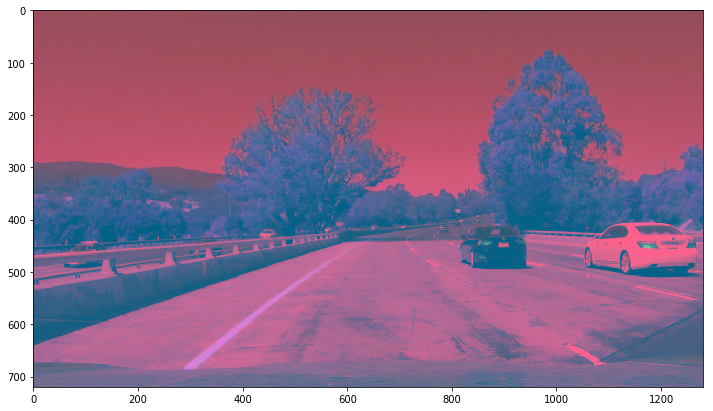

In [5]:
color_converted = convert_color(img, 'LUV')
plt.figure(figsize=(12, 10))
plt.imshow(color_converted)
plt.show()

/home/feklistoff/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(89, 159, 2, 2, 12)


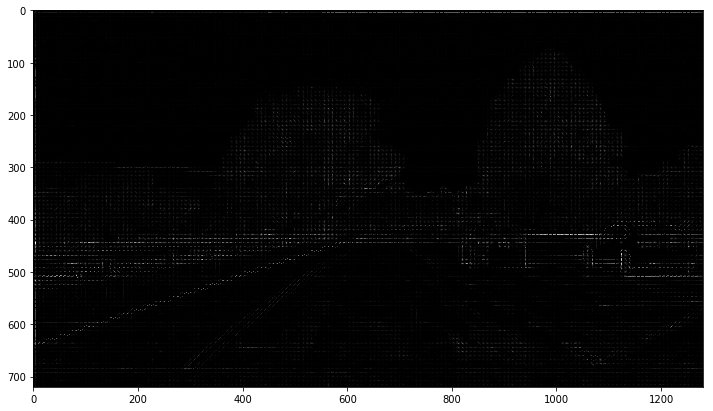

In [6]:
features, hog_img = get_hog_features(color_converted, orient=12, pix_per_cell=8, cell_per_block=2, 
                                     vis=True, feature_vec=False)
print(features.shape)
plt.figure(figsize=(12, 10))
plt.imshow(hog_img, cmap='gray')
plt.show()

/home/feklistoff/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(3, 3, 2, 2, 24)


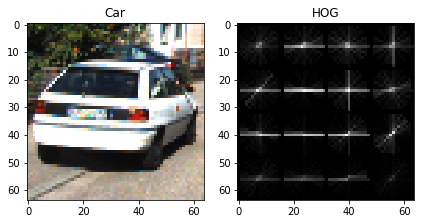

In [7]:
test1_c = convert_color(test1, 'YUV')
test1_1 = test1_c[:,:,0]
test1_2 = test1_c[:,:,1]
test1_3 = test1_c[:,:,2]

features, hog_img = get_hog_features(test1_1, orient=24, pix_per_cell=16, 
                                     cell_per_block=2, vis=True, feature_vec=False)

print(features.shape)

fig = plt.figure(figsize=(6, 8))
plt.subplot(121)
plt.imshow(test1)
plt.title('Car')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG')
fig.tight_layout()

In [8]:
# Read in cars and notcars
cars = glob.glob('./test_images/vehicles/**/*')
notcars = glob.glob('./test_images/non-vehicles/**/*')
print('number of car images:', len(cars))
print('number of non-car images:', len(notcars))

number of car images: 8792
number of non-car images: 17936


In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) define an empty list to receive features
    img_features = []
    #2) apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, color_space)
    else: feature_image = np.copy(img)      
    #3) compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) append features to list
        img_features.append(spatial_features)
    #5) compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) append features to list
        img_features.append(hist_features)
    #7) compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) append features to list
        img_features.append(hog_features)
    #9) return concatenated array of features
    return np.concatenate(img_features)

In [10]:
# function to pass an image and the list of windows to be searched
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) create an empty list to receive positive detection windows
    on_windows = []
    #2) iterate over all windows in the list
    for window in windows:
        #3) extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) predict using your classifier
        prediction = clf.predict(test_features)
        #7) if positive then save the window
        if prediction:
            on_windows.append(window)
    #8) return windows for positive detections
    return on_windows

w1: 117, w2: 75, w3: 57, total w: 249


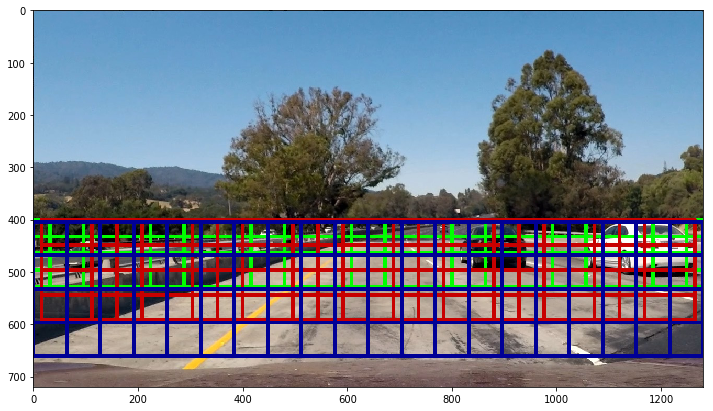

In [11]:
# draw all windows that we using for searching
img = test[3]
draw_image = np.copy(img)

y_strt_stp1 = [400, 528]
w1 = (64, 64)
y_strt_stp2 = [400, 592]
w2 = (96, 96)
y_strt_stp3 = [404, 660]
w3 = (128, 128)

windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_strt_stp1, 
                    xy_window=w1, xy_overlap=(0.5, 0.5))
windows2 = slide_window(img, x_start_stop=[(img.shape[1]-img.shape[1]//w2[0]*w2[0])//2, None], 
                        y_start_stop=y_strt_stp2, xy_window=w2, xy_overlap=(0.5, 0.5))
windows3 = slide_window(img, x_start_stop=[(img.shape[1]-img.shape[1]//w3[0]*w3[0])//2, None], 
                        y_start_stop=y_strt_stp3, xy_window=w3, xy_overlap=(0.5, 0.5))

print('w1: {}, w2: {}, w3: {}, total w: {}'. format(len(windows1), len(windows2),
                                                    len(windows3), len(windows1)+len(windows2)+len(windows3)))
window_img1 = draw_boxes(draw_image, windows1, color=(0, 255, 0), thick=6)                    
window_img2 = draw_boxes(window_img1, windows2, color=(200, 0, 0), thick=6)
window_img3 = draw_boxes(window_img2, windows3, color=(0, 0, 150), thick=6) 

plt.figure(figsize=(12, 10))
plt.imshow(window_img3)
plt.show()

In [12]:
# parameters
color_space = 'YUV' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 24  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # spatial binning dimensions
hist_bins = 16    # number of histogram bins
spatial_feat = False # spatial features on or off
hist_feat = False # histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 660] # min and max in y to search in slide_window()

In [13]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# use a linear SVC 
svc = LinearSVC(C=0.0005)
# check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# check the prediction time for a single sample
t=time.time()

/home/feklistoff/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 24 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 864
1.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9652


In [14]:
# save/load SVM model
from sklearn.externals import joblib

In [15]:
# save SVM model
stuff = {'scaler': X_scaler,
        'clf': svc}

joblib.dump(stuff, 'data_clf_scaler_yuv.p') 

['data_clf_scaler_yuv.p']

In [17]:
# load SVM model
stuff = joblib.load('data_clf_scaler_yuv.p')
X_scaler = stuff['scaler']
svc = stuff['clf']

/home/feklistoff/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


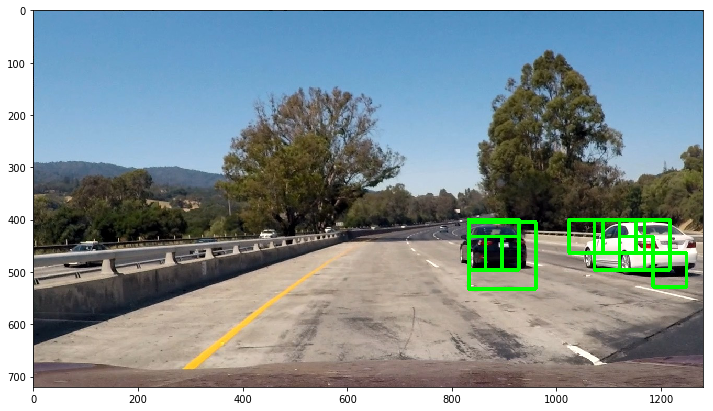

In [16]:
# test classifier
img = test[3]
draw_image = np.copy(img)

windows = windows1 + windows2 + windows3
hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

plt.figure(figsize=(12, 10))
plt.imshow(window_img)
plt.show()

In [17]:
# define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, color_space, channel):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # compute individual channel HOG features for the entire image
    if channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
     
    # define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # extract HOG for this patch
            if channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
 
            test_features = X_scaler.transform(hog_features.reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,
                              (xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 255, 0), 6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list

/home/feklistoff/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


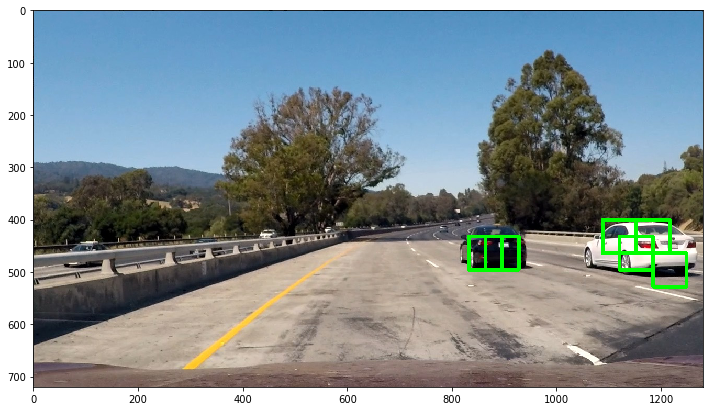

In [18]:
img = test[3]

channel = 0
ystart = 400
ystop = 660
scale = 1.0
    
out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, color_space, channel)


plt.figure(figsize=(12, 10))
plt.imshow(out_img)
plt.show()

In [19]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # add += 1 for all pixels inside each bbox
        # assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def heat_threshold(heatmap, threshold):
    # zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 255, 0), 6)
    return img

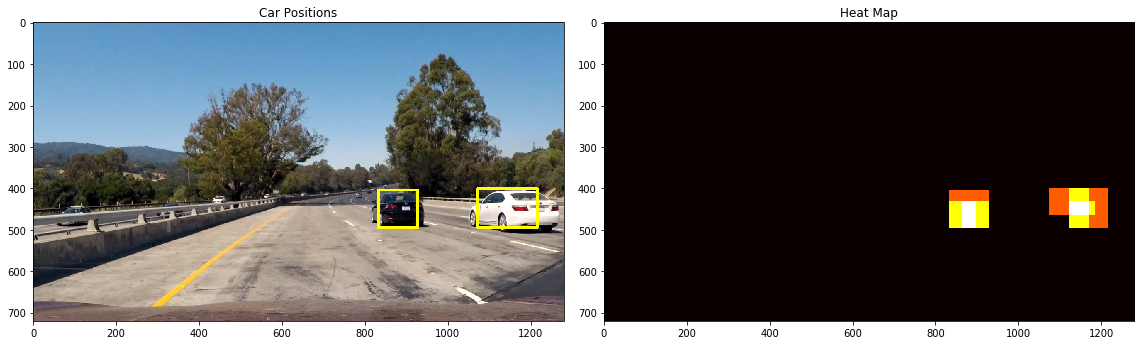

In [20]:
# add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, hot_windows)
    
# apply threshold to help remove false positives
heat = heat_threshold(heat, 1)

# visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()